In [1]:
%pip install kagglehub --quiet
import kagglehub
import shutil
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split

Note: you may need to restart the kernel to use updated packages.


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Frame The Problem And Look At The Big Picture

1. **Define the objective in business terms**:

   The Bronx Zoo in New York has engaged us to enhance their animal tracking capabilities. The Chief Technical Officer aims to update their existing image database of zoo animals in order to develop a system that can predict whether an animal is in its designated pen—eliminating the need for manual checks.

2. **How will your solution be used**:

   Our solution will be used to determine whether each animal is in its correct pen. The model will be run once daily to confirm that all animals have successfully returned to their enclosures by the end of the day.

3. **Current solutions/workarounds**:

   - **Manual animal species tagging**: Biologists will look at a animal and inspect it to make sure that it is sent to the right enclosure.

4. **Problem framing**:

   - **Supervised learning**: We have labeled data (pictures with labels).
   - **Multi-class classification**: The task is to classify pictures of animals into the 10 respective classes.
   - **Use case**: The system will be used in the Bronx zoo to classify animals to make sure they go to the right enclosure.

5. **Performance measurement**:

   - **Precision (macro)**: We are using precision (macro) because we are highly concerned that if we miss classify a animal like a bobcat and a coyote and they end up in the same enclosure could mean very big issues for the zoo and animals.
   - **Success criteria**: A precision of 80% would be acceptable in this problem because the workers would get a general idea and a expert could give the animal classification a once over to ensure, which would keep the process efficient.

6. **Comparable problems**:

   - **Computer Vision**: most if not all of the comparable problems to our business problem are all some sort of computer vision classification. Like intel image classification, and even things like urban sound 8k because they train on spectograms.

7. **Human expertise availability**:

   - **Biology experts**: While biology experts can accuracy classify animals to make sure they are being directed to the right enclosure but this takes a large amount of time, our aim is to shorten this process by providing a service to classify the animals to the correct enclosures only requiring a once over from the expert.
   - **Availability**: There is available expertise in the bronx zoo, this expertise include people that can accurately classify animals to the correct enclosures.

8. **Manual solution process**:

   A human would:
      Ask experts in the field to classify these animals, this way the animals would be correctly classified into the correct enclosures.

### Downloading the data

This script downloads the Animals10 dataset and organizes it into a flat directory structure. It renames the Italian class folder names to English using a translation dictionary. Finally, it creates a Pandas DataFrame with image file paths and their corresponding labels for training.

In [2]:
def download_data():
    path = kagglehub.dataset_download("alessiocorrado99/animals10")

    translate = {
        "cane": "dog",
        "cavallo": "horse",
        "elefante": "elephant",
        "farfalla": "butterfly",
        "gallina": "chicken",
        "gatto": "cat",
        "mucca": "cow",
        "pecora": "sheep",
        "ragno": "spider",
        "scoiattolo": "squirrel",
    }

    os.makedirs("./data", exist_ok=True)
    shutil.move(path, "./data")
    for directory in os.listdir("./data/2/raw-img"):
        full_path = os.path.join("./data/2/raw-img", directory)
        if os.path.isdir(full_path):
            shutil.move(full_path, "./data")
    shutil.rmtree("./data/2")

    for folder in os.listdir("./data"):
        full_path = os.path.join("./data", folder)
        if os.path.isdir(full_path):
            new_folder_name = translate.get(folder, folder)
            new_full_path = os.path.join("./data", new_folder_name)
            if new_full_path != full_path:
                os.rename(full_path, new_full_path)

    print("Dataset downloaded and organized in './data' directory.")

def load_meta_data():
    file_names = []
    labels = []

    for folder in os.listdir("./data"):
        for file in os.listdir(os.path.join("./data", folder)):
            full_path = os.path.join("./data", folder, file)
            if os.path.isfile(full_path):
                file_names.append(full_path)
                labels.append(folder)

    meta_data = pd.DataFrame({
        'file_path': file_names,
        'label': labels
    })
    meta_data['label'] = meta_data['label'].astype('category')
    return train_test_split(meta_data, test_size=0.2, random_state=42, stratify=meta_data['label'])

In [3]:
# download_data()
train_set, test_set = load_meta_data()
train_set.head(10)

,file_path,label
5528,./data/dog/OIP-447x3pE0J2i3e4Se0DAhKwHaNK.jpeg,dog
18394,./data/horse/OIP-lS06W6bD81zXI1l_yxfwUAHaGv.jpeg,horse
2336,./data/butterfly/OIP-ws2h3X3_VO-P5TWBwGPgAAHaG...,butterfly
17932,./data/chicken/OIP-eh6O4e9w5XhHROtHomauBwHaFj....,chicken
20729,./data/horse/OIP-SrtJbq9KbmFcqJQOkLY5UwHaGz.jpeg,horse
14505,./data/spider/OIP-Vr6LXQQv7OQoJNuxgUQw3wHaE8.jpeg,spider
17957,./data/chicken/OIP-S8bjrZRD4nCWgig5nQsSEQHaFj....,chicken
23539,./data/cow/OIP-kiGOyB5gfWZjscpzlKrggAHaF0.jpeg,cow
24760,./data/elephant/OIP-75pmfkEuZ6XUYXX2ZdnvhgHaE9...,elephant
24748,./data/elephant/OIP-sqR0uy956EHK8A6sMiaS9wAAAA...,elephant


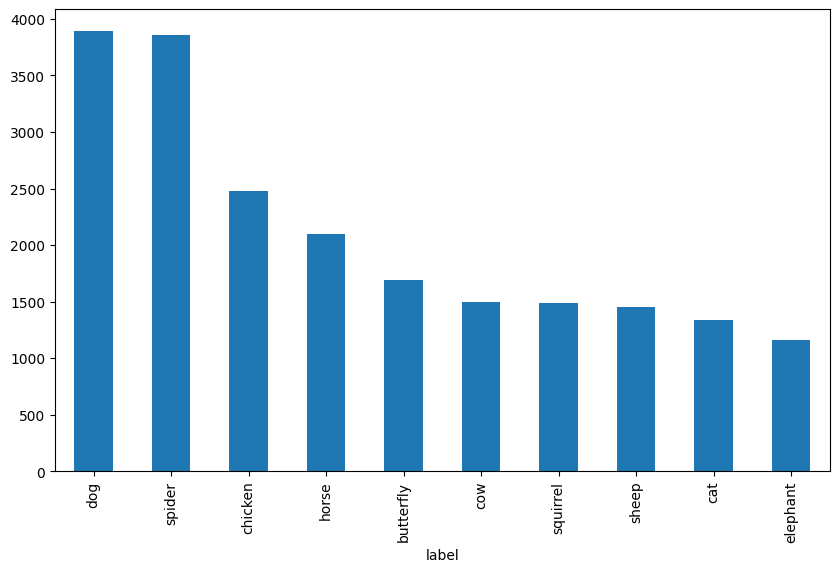

In [4]:
train_set["label"].value_counts().plot(kind='bar', figsize=(10, 6));

- Unbalanced class distribution so since we are using precision we must use the macro average of it.

In [5]:
def create_data_generators(train_set, test_set, img_size=(300, 300), batch_size=32):
    def pad_and_rescale(image):
        image = tf.image.resize_with_pad(image, target_height=img_size[0], target_width=img_size[1])
        image = image / 255.0
        return image
    
    train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )

    test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        preprocessing_function=pad_and_rescale
    )

    train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_set,
        directory=".",
        x_col="file_path",
        y_col="label",
        target_size=img_size,
        batch_size=batch_size,
        class_mode="categorical"
    )

    return train_generator, test_generator
train_generator, test_generator = create_data_generators(train_set, test_set)

Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


- Here we are creating preprocessing pipelines for the images to go into the model, the train set images are augmented to reduce overfitting.

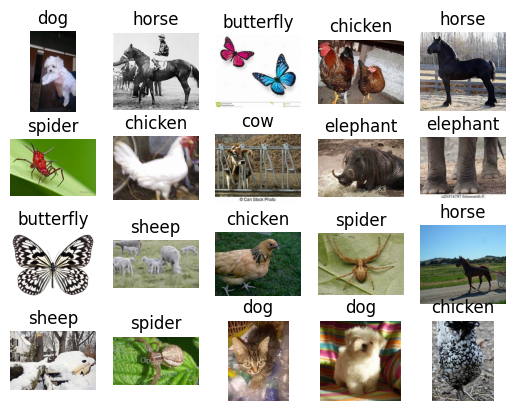

In [6]:
# plot the first 10 images from the training set not augmented
for i in range(20):
    img_path, label = train_set.iloc[i]
    img = plt.imread(img_path)
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

- These are our pictures before using the Tensorflow generators for augmentation.

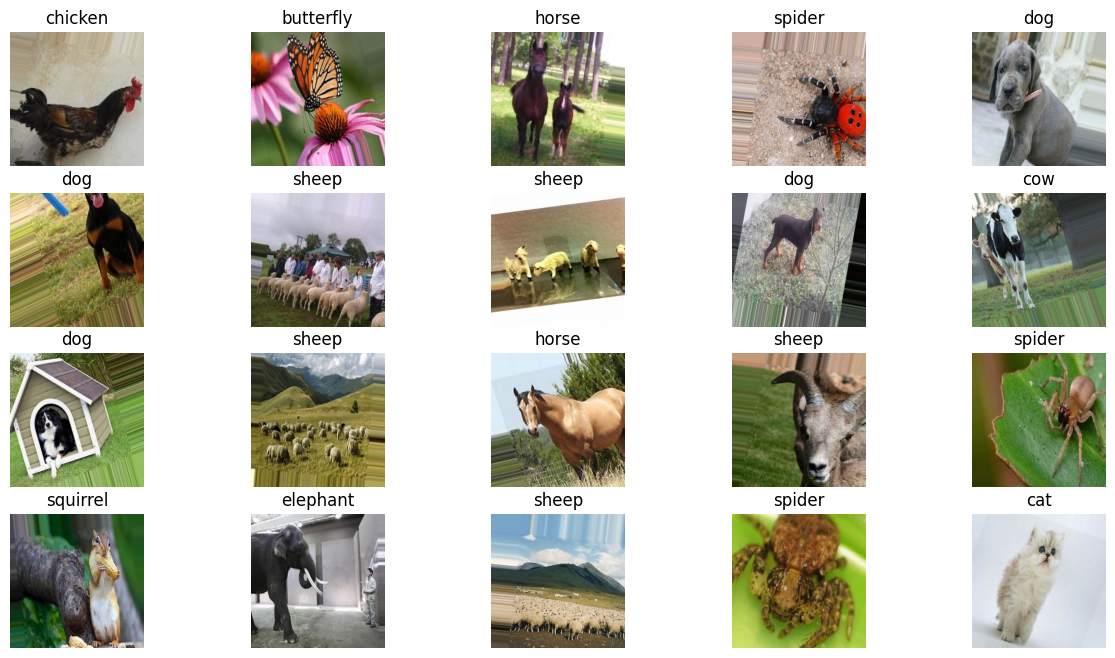

In [7]:
plt.figure(figsize=(15, 8))
for i, (img, label) in enumerate(zip(train_generator[0][0], train_generator[0][1])):
    if i >= 20:
        break
    plt.subplot(4, 5, i + 1)
    plt.imshow(img)
    class_names = {v: k for k, v in train_generator.class_indices.items()}
    plt.title(class_names[label.argmax()])
    plt.axis('off')

- Our pictures after running through the Tensorflow image generators where we augment the pictures and make sure every image is the same size.
- The test set is in the same image generator format but not augmented because this makes no sense instead we just make sure that the photos are in the correct size format and rescaled.

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [49]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 300, 300, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 300, 300, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_32 (MaxPooling2D) │ (None, 150, 150, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 150, 150, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 150, 150, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_33 (MaxPooling2D) │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 75, 75, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 75, 75, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_34 (MaxPooling2D) │ (None, 37, 37, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 37, 37, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 37, 37, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_35 (MaxPooling2D) │ (None, 18, 18, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │    21,233,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,658,442 (82.62 MB)

 Trainable params: 21,657,482 (82.62 MB)

 Non-trainable params: 960 (3.75 KB)

In [46]:
train_generator, test_generator = create_data_generators(train_set, test_set, img_size=(300, 300), batch_size=32)

Found 20943 validated image filenames belonging to 10 classes.
Found 5236 validated image filenames belonging to 10 classes.


In [50]:
history = model.fit(
    train_generator,
    epochs=30,
    validation_data=test_generator,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
        tf.keras.callbacks.ModelCheckpoint("best_model.keras", save_best_only=True, monitor='val_loss')
    ]
)

Epoch 1/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1383s 2s/step - accuracy: 0.2685 - loss: 3.3956 - val_accuracy: 0.4341 - val_loss: 1.6735
Epoch 2/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.4328 - loss: 1.6515 - val_accuracy: 0.4433 - val_loss: 1.6440
Epoch 3/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.5077 - loss: 1.4143 - val_accuracy: 0.5302 - val_loss: 1.3384
Epoch 4/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.5720 - loss: 1.2412 - val_accuracy: 0.5773 - val_loss: 1.2977
Epoch 5/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1335s 2s/step - accuracy: 0.6194 - loss: 1.1080 - val_accuracy: 0.5976 - val_loss: 1.1741
Epoch 6/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.6491 - loss: 1.0303 - val_accuracy: 0.6663 - val_loss: 1.0271
Epoch 7/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.6790 - loss: 0.9451 - val_accuracy: 0.4446 - val_loss: 1.8207
Epoch 8/30
655/655 ━━━━━━━━━━━━━━━━━━━━ 1329s 2s/step - accuracy: 0.6863 - loss: 0.9106 - 

```json
epochs=30, optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005), loss='categorical_crossentropy', metrics=['accuracy']
```
----------------
Epoch 1/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1383s 2s/step - accuracy: 0.2685 - loss: 3.3956 - val_accuracy: 0.4341 - val_loss: 1.6735
Epoch 2/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.4328 - loss: 1.6515 - val_accuracy: 0.4433 - val_loss: 1.6440
Epoch 3/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.5077 - loss: 1.4143 - val_accuracy: 0.5302 - val_loss: 1.3384
Epoch 4/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.5720 - loss: 1.2412 - val_accuracy: 0.5773 - val_loss: 1.2977
Epoch 5/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1335s 2s/step - accuracy: 0.6194 - loss: 1.1080 - val_accuracy: 0.5976 - val_loss: 1.1741
Epoch 6/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.6491 - loss: 1.0303 - val_accuracy: 0.6663 - val_loss: 1.0271
Epoch 7/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.6790 - loss: 0.9451 - val_accuracy: 0.4446 - val_loss: 1.8207
Epoch 8/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1329s 2s/step - accuracy: 0.6863 - loss: 0.9106 - val_accuracy: 0.6429 - val_loss: 1.1631
Epoch 9/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.7135 - loss: 0.8403 - val_accuracy: 0.6440 - val_loss: 1.3194
Epoch 10/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.7364 - loss: 0.7969 - val_accuracy: 0.5084 - val_loss: 2.3117
Epoch 11/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1328s 2s/step - accuracy: 0.7451 - loss: 0.7644 - val_accuracy: 0.7087 - val_loss: 0.9914
Epoch 12/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1328s 2s/step - accuracy: 0.7591 - loss: 0.7060 - val_accuracy: 0.7672 - val_loss: 0.7454
Epoch 13/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.7716 - loss: 0.6821 - val_accuracy: 0.7162 - val_loss: 0.9099
Epoch 14/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.7744 - loss: 0.6752 - val_accuracy: 0.7712 - val_loss: 0.7021
Epoch 15/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1329s 2s/step - accuracy: 0.7930 - loss: 0.6334 - val_accuracy: 0.7485 - val_loss: 0.8145
Epoch 16/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1364s 2s/step - accuracy: 0.7954 - loss: 0.6139 - val_accuracy: 0.7330 - val_loss: 0.8355
Epoch 17/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1333s 2s/step - accuracy: 0.8022 - loss: 0.5885 - val_accuracy: 0.4375 - val_loss: 4.6773
Epoch 18/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1341s 2s/step - accuracy: 0.8064 - loss: 0.5854 - val_accuracy: 0.7836 - val_loss: 0.6950
Epoch 19/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1337s 2s/step - accuracy: 0.8145 - loss: 0.5586 - val_accuracy: 0.7974 - val_loss: 0.7137
Epoch 20/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1333s 2s/step - accuracy: 0.8201 - loss: 0.5363 - val_accuracy: 0.7932 - val_loss: 0.6758
Epoch 21/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.8209 - loss: 0.5411 - val_accuracy: 0.7349 - val_loss: 0.9398
Epoch 22/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.8268 - loss: 0.5169 - val_accuracy: 0.8048 - val_loss: 0.6803
Epoch 23/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.8383 - loss: 0.4913 - val_accuracy: 0.7460 - val_loss: 1.0010
Epoch 24/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.8331 - loss: 0.4930 - val_accuracy: 0.8086 - val_loss: 0.7309
Epoch 25/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1333s 2s/step - accuracy: 0.8452 - loss: 0.4658 - val_accuracy: 0.8113 - val_loss: 0.6411
Epoch 26/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1332s 2s/step - accuracy: 0.8448 - loss: 0.4586 - val_accuracy: 0.7859 - val_loss: 0.8021
Epoch 27/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1346s 2s/step - accuracy: 0.8509 - loss: 0.4486 - val_accuracy: 0.7752 - val_loss: 0.9020
Epoch 28/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1357s 2s/step - accuracy: 0.8518 - loss: 0.4491 - val_accuracy: 0.7949 - val_loss: 0.7493
Epoch 29/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1331s 2s/step - accuracy: 0.8555 - loss: 0.4284 - val_accuracy: 0.7809 - val_loss: 0.7590
Epoch 30/30 <br>
655/655 ━━━━━━━━━━━━━━━━━━━━ 1330s 2s/step - accuracy: 0.8517 - loss: 0.4435 - val_accuracy: 0.5959 - val_loss: 2.0228

In [63]:
predictions = model.predict(test_generator, verbose=1)

164/164 ━━━━━━━━━━━━━━━━━━━━ 72s 433ms/step


In [52]:
for i in range(10):
    for x in predictions[i]:
        print(f"Prediction {i+1}: {x * 100:.2f}%")
    print("\n" + "="*50 + "\n")

Prediction 1: 1.77%
Prediction 1: 0.11%
Prediction 1: 96.19%
Prediction 1: 0.21%
Prediction 1: 0.94%
Prediction 1: 0.09%
Prediction 1: 0.06%
Prediction 1: 0.28%
Prediction 1: 0.30%
Prediction 1: 0.04%


Prediction 2: 97.05%
Prediction 2: 0.00%
Prediction 2: 0.00%
Prediction 2: 0.00%
Prediction 2: 0.00%
Prediction 2: 0.00%
Prediction 2: 0.00%
Prediction 2: 0.01%
Prediction 2: 2.94%
Prediction 2: 0.00%


Prediction 3: 0.05%
Prediction 3: 0.00%
Prediction 3: 0.01%
Prediction 3: 0.01%
Prediction 3: 0.02%
Prediction 3: 0.00%
Prediction 3: 0.02%
Prediction 3: 0.00%
Prediction 3: 99.89%
Prediction 3: 0.00%


Prediction 4: 0.06%
Prediction 4: 0.33%
Prediction 4: 0.06%
Prediction 4: 0.16%
Prediction 4: 93.98%
Prediction 4: 0.01%
Prediction 4: 5.07%
Prediction 4: 0.03%
Prediction 4: 0.24%
Prediction 4: 0.08%


Prediction 5: 0.00%
Prediction 5: 0.01%
Prediction 5: 0.04%
Prediction 5: 1.72%
Prediction 5: 0.50%
Prediction 5: 1.06%
Prediction 5: 96.61%
Prediction 5: 0.01%
Prediction 5: 0.00%
Predict

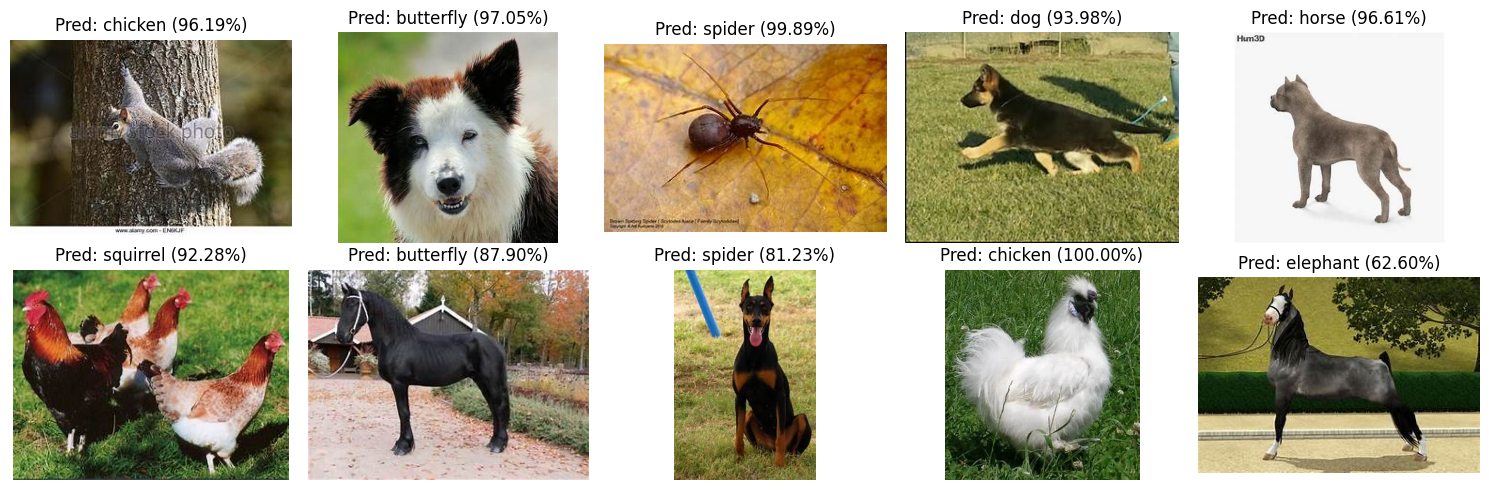

In [56]:
import matplotlib.image as mpimg
class_names = list(test_generator.class_indices.keys())
plt.figure(figsize=(15, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    img = mpimg.imread(test_generator.filepaths[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Pred: {class_names[np.argmax(predictions[i])]} ({predictions[i][np.argmax(predictions[i])]*100:.2f}%)")
plt.tight_layout()

- Hilariously bad its basically just guessing that it is always going to be a spider, but on the actual spider it thinks it is going to be a butterfly.
- The percentage values is the confidence value so top right dog with a prediction of spider 82.01% means that the model is 82.01% certain that it is a spider.
- definitely some modifications we need to make to the model.

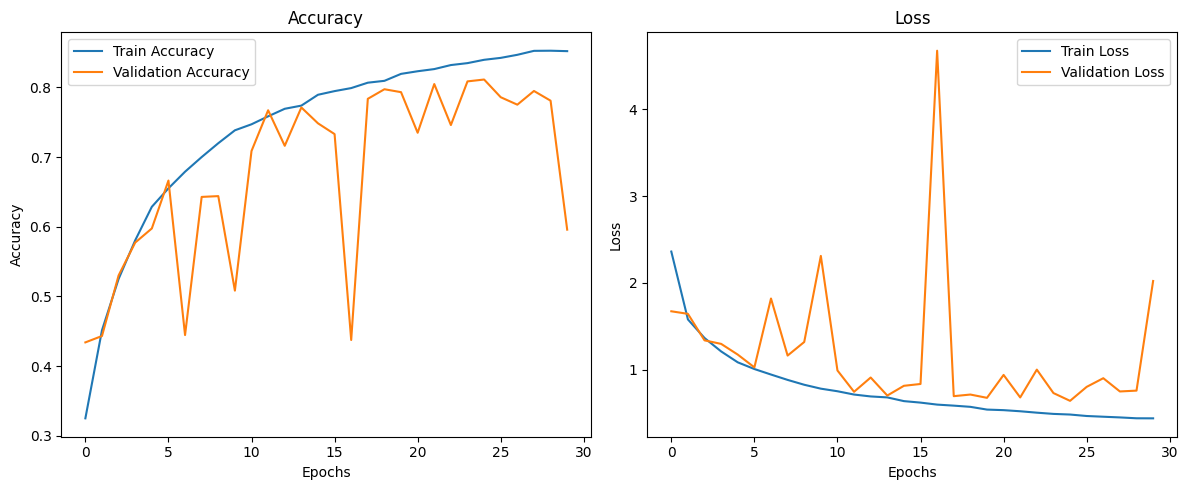

In [57]:
# plotting the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

- Graph of the train and validation, accuracy and loss over epochs.

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")
recall = tf.keras.metrics.Recall()
precision = tf.keras.metrics.Precision()
recall.update_state(test_generator.classes, np.argmax(predictions, axis=1))
precision.update_state(test_generator.classes, np.argmax(predictions, axis=1))
print(f"Recall: {recall.result().numpy() * 100:.2f}%")
print(f"Precision: {precision.result().numpy() * 100:.2f}%")

164/164 ━━━━━━━━━━━━━━━━━━━━ 66s 403ms/step - accuracy: 0.8018 - loss: 0.7023
Test Accuracy: 81.13%
Recall: 91.17%
Precision: 91.76%


- Honestly pretty good
- Expected a lot worse we are going to h ave to try some more models or try a grid search but honestly pretty good.

```json
'param_grid' = {
    'optimizer': ['adam', 'sgd'],
    'batch_size': [16, 32],
    'epochs': [10, 20]
}
```

In [11]:
def create_model(optimizer='adam'):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(300, 300, 3)),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',
        metrics=['precision', 'recall', 'accuracy']
    )
    return model

for optimizer in ['adam', 'sgd']:
    for batch_size in [16, 32]:
        for epochs in [10, 20]:
            print(f"Training with: {optimizer}, {batch_size}, {epochs}")

            model = create_model(optimizer=optimizer)

            history = model.fit(
                train_generator,
                epochs=epochs,
                validation_data=test_generator,
                steps_per_epoch=len(train_generator),
                validation_steps=len(test_generator),
                batch_size=batch_size
            )
            test_loss, test_precision, test_recall, test_accuracy = model.evaluate(test_generator)
            print(f"Params: {optimizer}, {batch_size}, {epochs}")
            print(f"Test Accuracy: {test_accuracy * 100:.2f}%, Test Precision: {test_precision * 100:.2f}%, Test Recall: {test_recall * 100:.2f}%, Test Loss: {test_loss:.4f}")
            print("-" * 50)

Training with: adam, 16, 10


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1139s 2s/step - accuracy: 0.2172 - loss: 5.5640 - precision: 0.2627 - recall: 0.1102 - val_accuracy: 0.3419 - val_loss: 1.9342 - val_precision: 0.5445 - val_recall: 0.0619
Epoch 2/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 2499s 4s/step - accuracy: 0.3493 - loss: 1.8425 - precision: 0.6049 - recall: 0.1164 - val_accuracy: 0.4771 - val_loss: 1.5517 - val_precision: 0.6239 - val_recall: 0.3361
Epoch 3/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1148s 2s/step - accuracy: 0.4604 - loss: 1.5724 - precision: 0.6642 - recall: 0.2406 - val_accuracy: 0.3359 - val_loss: 2.3637 - val_precision: 0.4586 - val_recall: 0.2498
Epoch 4/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1110s 2s/step - accuracy: 0.5161 - loss: 1.3991 - precision: 0.7055 - recall: 0.3291 - val_accuracy: 0.5084 - val_loss: 1.4300 - val_precision: 0.6668 - val_recall: 0.3260
Epoch 5/10
655/655 ━━━━━━━━━━━━━━━━━━━━ 1165s 2s/step - accuracy: 0.5653 - loss: 1.2496 - precision: 0.7332 - recall: 0.4007 - val_accuracy: 0.4139 - va

- Our grid search points to the following param grid being the best:
```json
param_grid = {

}
```

Our metrics from the grid search.